<a href="https://colab.research.google.com/github/nfaggian/record_linkage/blob/master/link.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Record linkage 

## Dependencies
- - - 

Jellyfish is a library for comparing strings: [github](https://github.com/jamesturk/jellyfish )

In [2]:
!pip install jellyfish tqdm

    100% |████████████████████████████████| 133kB 5.9MB/s 
  Running setup.py bdist_wheel for jellyfish ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/9c/6f/33/92bb9a4b4562a60ba6a80cedbab8907e48bc7a8b1f369ea0ae
Successfully built jellyfish


In [0]:
import numpy as np
import pandas as pd
import tqdm

import uuid

import jellyfish as jf
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import HTML, display, clear_output
from google.colab import auth

## GCP authentication
- - - 

In [4]:
auth.authenticate_user()

%env GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian

project_id = 'anz-pso-nfaggian'

env: GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian


## Retrieve donor and contributions data

In [5]:
query = f"""
SELECT
  *
FROM
  dedup.donors
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 500) = 0
"""

raw_donors = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard', verbose=False)
raw_donors = raw_donors.sort_values(by='donor_id')
print(raw_donors.shape)
raw_donors.head()

(1410, 10)


,donor_id,last_name,first_name,address_1,address_2,city,state,zip,employer,occupation
442,404,1-28-07 cash deposits,None,None,None,None,il,None,None,None
1064,422,12 congressional district afl-cio cope cont. fund,None,59 magnolia dr.,None,belleville,il,62221,None,None
602,616,1420 west lexington partnership,None,1420 west lexington partnership,None,chicago,il,60607,None,None
629,988,18th ward democratic org,None,8150 s kedzie ave,None,chicago,il,60652,None,None
1114,1906,3131 w. logan llc,None,3375 commercial avenue,None,northbrook,il,60062,None,None


In [94]:
query = f"""
SELECT
  *
FROM
  dedup.contributions
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 500) = 0
"""

raw_donations = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard', verbose=False)
raw_donations = raw_donations.sort_values(by='donor_id')
print(raw_donations.shape)
raw_donations.head()

(3463, 20)


,contribution_id,donor_id,recipient_id,report_type,date_recieved,loan_amount,amount,receipt_type,vendor_last_name,vendor_first_name,vendor_address_1,vendor_address_2,vendor_city,vendor_state,vendor_zip,description,election_type,election_year,report_period_begin,report_period_end
909,2236671,404,15703,,2007-01-28,0.0,129.0,Individual Contribution,,,,,,,,,,,2007-01-01,2007-06-30
2404,1092192,422,16682,,2002-08-07,0.0,300.0,Transfer In,,,,,,,,,,,2002-07-01,2002-12-31
3058,955071,616,15366,,2002-02-22,0.0,600.0,Individual Contribution,,,,,,,,,,,2002-01-01,2002-06-30
2025,3365908,988,1157,None,2011-08-18,0.0,200.0,Transfer In,None,None,None,None,None,,,None,,,2011-07-01,2011-09-30
496,1719057,1906,17037,,2005-03-25,0.0,1000.0,Individual Contribution,,,,,,,,,,,2005-01-01,2005-06-30


**Data preperation**
- - - 

In [0]:
def transform(record):
  """
  Perform some simple transformations on the record.
  """
  
  # combine the first and last name
  return {
      'donor_id': record.donor_id,
          'city': f"{record.city or ' '}".strip().lower(),
          'name': f"{record.first_name or ' '} {record.last_name or ' '}".strip().lower(),
       'address': f"{record.address_1 or ' '} {record.address_2 or ' '}".strip().lower(), 
         'state': f"{record.state or ' '}".strip().lower(),
           'zip': f"{record.zip or ' '}".strip().lower(),
    'occupation': f"{record.occupation or ' '}".strip().lower(),
      'employer': f"{record.employer or ' '}".strip().lower(),
     'is_person': record.first_name is not None }

In [7]:
donors = [] 
for row, record in tqdm.tqdm(raw_donors.iterrows(), total=raw_donors.shape[0]):
  donors.append(transform(record))
donors = pd.DataFrame(donors)
donors.head()

100%|██████████| 1410/1410 [00:00<00:00, 5478.59it/s]


,address,city,donor_id,employer,is_person,name,occupation,state,zip
0,,,404,,False,1-28-07 cash deposits,,il,
1,59 magnolia dr.,belleville,422,,False,12 congressional district afl-cio cope cont. fund,,il,62221
2,1420 west lexington partnership,chicago,616,,False,1420 west lexington partnership,,il,60607
3,8150 s kedzie ave,chicago,988,,False,18th ward democratic org,,il,60652
4,3375 commercial avenue,northbrook,1906,,False,3131 w. logan llc,,il,60062


## Comparing duplicated donor data
- - -

In [0]:
data = []

def comparator(record_a, record_b):
  """
  Compares one field to another, using a series of distance metrics.
  """
  
  return {
    'donor_id1': record_a.donor_id,
    'donor_id2': record_b.donor_id,
    # name
    'jaro_name': jf.jaro_winkler(record_a['name'], record_b['name']),
    'phonetic_name': jf.match_rating_comparison(record_a['name'], record_b['name']),
    'damerau_name': jf.damerau_levenshtein_distance(record_a['name'], record_b['name']),
    # address  
    'jaro_address': jf.jaro_winkler(record_a['address'], record_b['address']),
    'phonetic_address': jf.match_rating_comparison(record_a['address'], record_b['address']),  
    'damerau_address': jf.damerau_levenshtein_distance(record_a['address'], record_b['address']),  
    # city
    'jaro_city': jf.jaro_winkler(record_a['city'], record_b['city']),  
    'damerau_city': jf.damerau_levenshtein_distance(record_a['city'], record_b['city']),  
    # occupation
    'jaro_occupation': jf.jaro_winkler(record_a['occupation'], record_b['occupation']),
    'damerau_occupation': jf.damerau_levenshtein_distance(record_a['occupation'], record_b['occupation']),
    # state
    'jaro_state': jf.jaro_winkler(record_a['state'], record_b['state']),
    'damerau_state': jf.damerau_levenshtein_distance(record_a['state'], record_b['state'])
  }


In [9]:
distance_table = []
for row_a, record_a in tqdm.tqdm(donors.iterrows(), total=donors.shape[0]):
  for row_b, record_b in donors.iterrows():
    if row_a == row_b: continue    
    distance_table.append(comparator(record_a, record_b)) 
distance_table = pd.DataFrame(distance_table)

100%|██████████| 1410/1410 [09:50<00:00,  2.40it/s]


In [0]:
distance_table = distance_table.sort_values(by='jaro_name', ascending=False)

From the dataset (in the small sample) we can see that the patterns of similarity:

* Using the jaro-winkler distance we can see that there are patches of highly similary values (close to 1). 
* Using the damerau distance the patterns are a bit different, it is more sensitive to larger edits and unbound. 

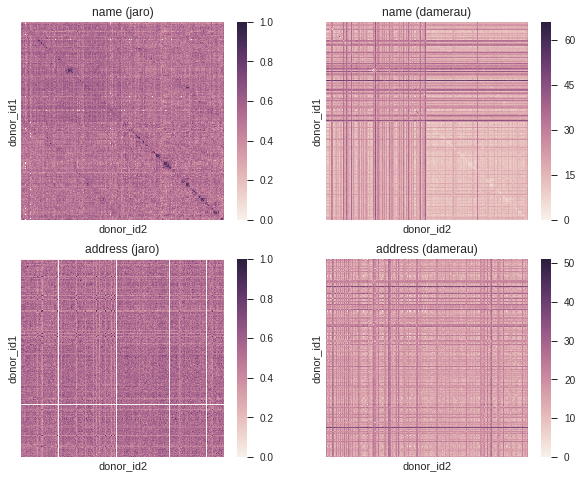

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.set(style="ticks")
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'jaro_name'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax1)
ax1.set_title('name (jaro)')
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'damerau_name'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax2)
ax2.set_title('name (damerau)')
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'jaro_address'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax3)
ax3.set_title('address (jaro)')
sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'damerau_address'), 
            xticklabels=False, yticklabels=False, annot=False, ax=ax4)
ax4.set_title('address (damerau)');


## Building a simple baseline model
- - -

Using the metrics we just calculated - let us build a simple duplicate detector, based on the following rules:

* jaro distances which are closer to 1.0 are good examples of duplicates.
* damerau distances which are closer to zero are good example of duplicates. 

We can set this threshold by looking at the distribution of the distance metrics for our small dataset, under the assumption that our small sample contains some of the common errors we will see in the larger dataset.

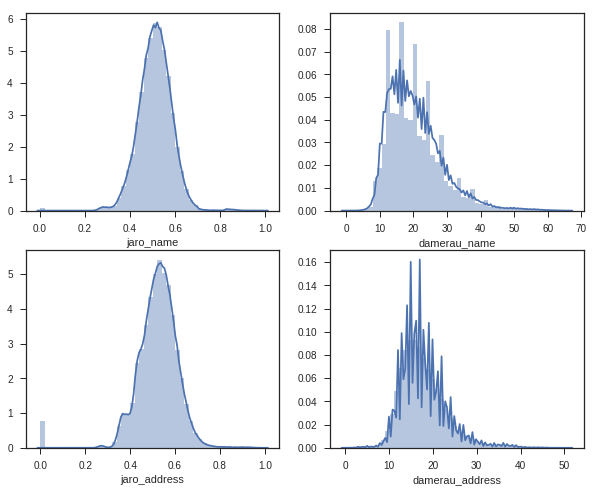

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.set(style="ticks")
sns.distplot(distance_table['jaro_name'], ax=ax1)
sns.distplot(distance_table['damerau_name'], ax=ax2)
sns.distplot(distance_table['jaro_address'], ax=ax3)
sns.distplot(distance_table['damerau_address'], ax=ax4);

In [38]:
print(f"""
 jaro_name    :{distance_table['jaro_name'].quantile(0.99)}
 jaro_address :{distance_table['jaro_address'].quantile(0.99)}
 damerau_name    :{distance_table['damerau_name'].quantile(0.01)}
 damerau_address :{distance_table['damerau_address'].quantile(0.01)}
""") 


 jaro_name    :0.672163144433975
 jaro_address :0.7110177404295052
 damerau_name    :9.0
 damerau_address :9.0



Using the mean operator we can form a simple classifier that assumes equal importance of each distance metric:

In [0]:
def baseline_classifier(record):
    """
    Simple voting classifier.
    * assumes an equal weighting for the different types of distance metrics. 
    """
    votes = [
        record['jaro_name'] > 0.67,
        record['jaro_address'] > 0.67,
        record['damerau_name'] < 9,
        record['damerau_address'] < 9]
    return np.mean(votes)    

##Using the baseline model

In [52]:
classification_column = []
for row, record in tqdm.tqdm(distance_table.iterrows(), total=distance_table.shape[0]):
  classification_column.append(baseline_classifier(record))

100%|██████████| 1986690/1986690 [03:57<00:00, 8349.17it/s]


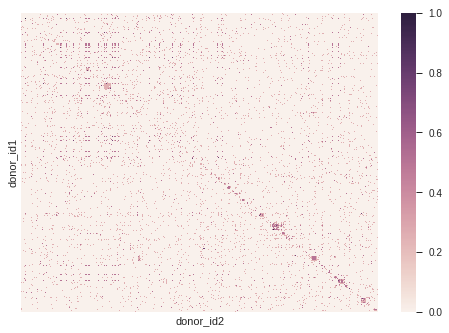

In [71]:
distance_table['duplicate'] = np.array(classification_column) > 0.5
distance_table['duplicate_score'] = np.array(classification_column)

sns.heatmap(distance_table.pivot('donor_id1', 'donor_id2', 'duplicate_score'), 
            xticklabels=False, yticklabels=False, annot=False);

## Clustering
- - -

Using a "greedy" clustering algorithm we can form a distinct set of clustered records. We restrict the donors to one distinct cluster and ignore potential overlaps. 

In [0]:
redux = distance_table[['donor_id1', 'donor_id2', 'duplicate', 'duplicate_score']]

donor_map = {}

duplicates = set([])

for donor_id, frame in redux.groupby(['donor_id1']):
  
  if donor_id in duplicates: continue
  
  # Form a unique identifier
  cluster_id = uuid.uuid4()
  donor_map[donor_id] = cluster_id
  
  # Map the donor_ids in the cluster to the same cluster identifier
  for matched_donor in frame[frame['duplicate']]['donor_id2']:
    donor_map[matched_donor] = cluster_id
    duplicate_set.add(matched_donor)

After forming a new identifier for clusters we can add them to the donor and donation tables.

In [0]:
raw_donations['cluster_id'] = raw_donations['donor_id'].apply(lambda x: donor_map[x])

donors['cluster_id'] = donors['donor_id'].apply(lambda x: donor_map[x])

## Solving the problem (reduced set)

- - - 

On the reduced dataset using the **donor identifier**:

In [164]:
top_donations = raw_donations.pivot_table(index='donor_id', aggfunc=sum)[['amount']].sort_values('amount', ascending=False).head(10).reset_index()

pd.merge(top_donations, donors, on='donor_id')[['name', 'amount']].head(10)

,name,amount
0,illinois health care association pac,1899057.60
1,upspac,109950.00
2,chicago & northeast il dist - carpenters pac,109000.00
3,chicago federation of labor & iuc political fund,90409.29
4,citizens for stephens,67726.51
5,mid-america convalescent ctr.,57876.05
6,john a. darrow,46288.60
7,regency hc & rehab ctr,42986.66
8,kimball hill inc.,37900.00
9,nikolaos manousopoulos,37486.62


On the reduced dataset using the newly formed **cluster identifier**:

In [165]:
top_donations = raw_donations.pivot_table(index='cluster_id', aggfunc=sum)[['amount']].sort_values('amount', ascending=False).head(10).reset_index()

pd.merge(top_donations, donors, on='cluster_id')[['name', 'amount']].head(10)


,name,amount
0,iec,1899557.60
1,illinois health care association pac,1899557.60
2,chicago & northeast il dist - carpenters pac,110000.00
3,solum & hopper attorneys and counselors at law,110000.00
4,upspac,109950.00
5,chicago federation of labor & iuc political fund,90409.29
6,citizens for stephens,68226.51
7,theis for supreme court,68226.51
8,mid-america convalescent ctr.,57876.05
9,john a. darrow,46288.60


# Next steps



## Building more complicated models
- - -

To build a more complicated classifier we need to first label some training data:

In [162]:
duplicate_set = set([])

for row, comparison in distance_table.iterrows():
    
    id1, id2 = comparison['donor_id1'], comparison['donor_id2']
    
    comparison_frame = donors[(donors.donor_id == id1) | (donors.donor_id == id2)].reset_index()
    
    display(HTML(comparison_frame.to_html()))
    
    duplicate_test = input('Is this a duplicate? (y,n,s)')
    
    if 's' in duplicate_test: 
      clear_output
      break
   
    if 'y' in duplicate_test: 
      duplicate_set.update([id1, id2])  
      clear_output()
    

,index,address,city,donor_id,employer,is_person,name,occupation,state,zip,cluster_id
0,550,100 south wacker dr. suite 700,chicago,262229,,False,primera engineers ltd.,,il,60606,df7ad9c8-4a5e-444e-9382-613a60244a11
1,551,100 s. wacker dr. st 700,chicago,262252,,False,primera engineers ltd.,,il,60602,df7ad9c8-4a5e-444e-9382-613a60244a11


Is this a duplicate? (y,n,s)s
